# Importing Dependencies

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import cv2


In [2]:
import pandas as pd

# Paths to the COCO dataset directories
train_dir = "../input/coco-2017-dataset/coco2017/train2017/"
test_dir = "../input/coco-2017-dataset/coco2017/test2017/"
val_dir = "../input/coco-2017-dataset/coco2017/val2017/"

# Function to list image IDs from directory
def list_image_ids(directory):
    return [file.split(".")[0] for file in os.listdir(directory)]

# List image IDs for each set
train_image_ids = list_image_ids(train_dir)
test_image_ids = list_image_ids(test_dir)
val_image_ids = list_image_ids(val_dir)

# Convert image IDs to pandas dataframes
train_image_names = pd.DataFrame(train_image_ids, columns=["img_id"])
test_image_names = pd.DataFrame(test_image_ids, columns=["img_id"])
val_image_names = pd.DataFrame(val_image_ids, columns=["img_id"])


# Loading COCO dataset annotations for training and validation sets.

In [19]:
# Define paths
annotations_path = '/kaggle/input/coco-2017-dataset/coco2017/annotations/'

# Load the annotations
with open(os.path.join(annotations_path, 'captions_train2017.json'), 'r') as f:
    train_captions = json.load(f)

with open(os.path.join(annotations_path, 'captions_val2017.json'), 'r') as f:
    val_captions = json.load(f)

# Example to check the structure
print(train_captions.keys())
print(val_captions.keys())

dict_keys(['info', 'licenses', 'images', 'annotations'])
dict_keys(['info', 'licenses', 'images', 'annotations'])


# Extracting image IDs from COCO dataset annotations for training and validation sets and converting them into pandas dataframes.

In [4]:
# Function to extract image IDs from the annotations
def extract_image_ids(captions):
    image_ids = [ann['image_id'] for ann in captions['annotations']]
    return image_ids

# Extract image IDs for training and validation
train_image_ids = extract_image_ids(train_captions)
val_image_ids = extract_image_ids(val_captions)

# Convert to pandas dataframes
train_image_names = pd.DataFrame(train_image_ids, columns=["img_id"])
val_image_names = pd.DataFrame(val_image_ids, columns=["img_id"])

print(train_image_names.head())
print(val_image_names.head())

   img_id
0  203564
1  322141
2   16977
3  106140
4  106140
   img_id
0  179765
1  179765
2  190236
3  331352
4  517069


# 82.7% Train set, 14.6% Test set, 2.7% Validation set

In [5]:
import os

# Define paths to the image directories
train_images_dir = "/kaggle/input/coco-2017-dataset/coco2017/train2017/"
test_images_dir = "/kaggle/input/coco-2017-dataset/coco2017/test2017/"
val_images_dir = "/kaggle/input/coco-2017-dataset/coco2017/val2017/"

# Count the number of images in each directory
train_image_count = len(os.listdir(train_images_dir))
test_image_count = len(os.listdir(test_images_dir))
val_image_count = len(os.listdir(val_images_dir))

# Print the counts
print("Number of images in train set:", train_image_count)
print("Number of images in test set:", test_image_count)
print("Number of images in validation set:", val_image_count)

Number of images in train set: 118287
Number of images in test set: 40670
Number of images in validation set: 5000


# Visualizing a randomly selected image from the COCO 2017 dataset.

Image file: 000000324870.jpg
Image dimensions: 640 x 424
Number of channels: 3


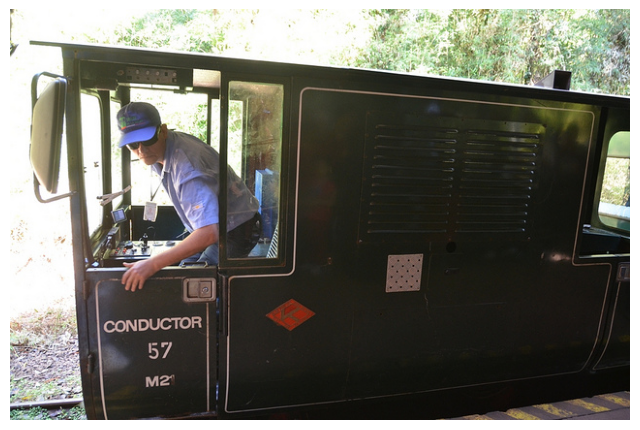

In [6]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Directory where the images are extracted
extract_dir = "../input/coco-2017-dataset/coco2017/train2017"

# List all image files in the directory
image_files = os.listdir(extract_dir)

# Shuffle the list to randomly select an image
random.shuffle(image_files)

# Select the first image file for visualization
image_file = image_files[0]

# Read the image using OpenCV
img = cv2.imread(os.path.join(extract_dir, image_file))

# Check if the image was loaded successfully
if img is not None:
    # Get image dimensions
    height, width, channels = img.shape

    # Display basic information about the image
    print("Image file:", image_file)
    print("Image dimensions: {} x {}".format(width, height))
    print("Number of channels:", channels)

    # Visualize the image with good quality
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("Error: Unable to load the image.")

# Loading and printing the keys of a JSON annotations file from the COCO dataset

In [7]:
import json

# Path to the annotations file
annotations_file_path = "../input/coco-2017-dataset/coco2017/annotations/instances_train2017.json"

# Load the annotations file
with open(annotations_file_path, "r") as f:
    data = json.load(f)

# Print the keys of the loaded JSON object
print(data.keys())

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


# Loading COCO dataset annotations from a JSON file and converting them into a pandas DataFrame.

In [8]:
# Define the path to the annotations file
annotations_file_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"

# Check if the file exists
if os.path.exists(annotations_file_path):
    # Load the annotations file
    with open(annotations_file_path, 'r') as file:
        annotations_data = json.load(file)

    # Convert annotations data to DataFrame
    coco_annotations = pd.DataFrame(annotations_data['annotations'])

    # Display the first few rows of the DataFrame
    print(coco_annotations.head())
else:
    print("Error: Annotations file not found.")

   image_id   id                                            caption
0    203564   37  A bicycle replica with a clock as the front wh...
1    322141   49  A room with blue walls and a white sink and door.
2     16977   89  A car that seems to be parked illegally behind...
3    106140   98  A large passenger airplane flying through the ...
4    106140  101  There is a GOL plane taking off in a partly cl...


In [9]:
# Print the head of the train_image_names DataFrame
print(train_image_names.head())

   img_id
0  203564
1  322141
2   16977
3  106140
4  106140


# Extracting image IDs and captions from the COCO dataset annotations file and storing them in a dictionary, then converting the image IDs to integer format

In [10]:
import json
from tqdm import tqdm

# Path to the annotations file
annotations_file_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"

# Load the annotations file
with open(annotations_file_path, 'r') as file:
    annotations_data = json.load(file)

# Extract image IDs and captions from the annotations
image_captions = {}
for annotation in tqdm(annotations_data['annotations']):
    image_id = str(annotation['image_id'])
    caption = annotation['caption']
    if image_id not in image_captions:
        image_captions[image_id] = []
    image_captions[image_id].append(caption)

# Convert image IDs to integer format
image_captions = {int(k): v for k, v in image_captions.items()}

# Preview the first few items in the dictionary
print("Preview of the image captions dictionary:")
for image_id, captions in list(image_captions.items())[:5]:
    print("Image ID:", image_id)
    print("Captions:", captions)
    print()

100%|██████████| 591753/591753 [00:00<00:00, 756577.31it/s]


Preview of the image captions dictionary:
Image ID: 203564
Captions: ['A bicycle replica with a clock as the front wheel.', 'The bike has a clock as a tire.', 'A black metal bicycle with a clock inside the front wheel.', 'A bicycle figurine in which the front wheel is replaced with a clock\n', 'A clock with the appearance of the wheel of a bicycle ']

Image ID: 322141
Captions: ['A room with blue walls and a white sink and door.', 'Blue and white color scheme in a small bathroom.', 'This is a blue and white bathroom with a wall sink and a lifesaver on the wall.', 'A blue boat themed bathroom with a life preserver on the wall', 'A bathroom with walls that are painted baby blue.']

Image ID: 16977
Captions: ['A car that seems to be parked illegally behind a legally parked car', 'two cars parked on the sidewalk on the street', 'City street with parked cars and a bench.', 'Cars try to maneuver into parking spaces along a densely packed city street. ', 'A couple of cars parked in a busy str

In [11]:
coco_annotations.head()

image_id   id                                            caption
0    203564   37  A bicycle replica with a clock as the front wh...
1    322141   49  A room with blue walls and a white sink and door.
2     16977   89  A car that seems to be parked illegally behind...
3    106140   98  A large passenger airplane flying through the ...
4    106140  101  There is a GOL plane taking off in a partly cl...

In [12]:
import json

# Path to the annotations file
annotations_file_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"

# Load the annotations file
with open(annotations_file_path, 'r') as file:
    annotations_data = json.load(file)

# Convert annotations data to a DataFrame
annotations_df = pd.DataFrame(annotations_data["annotations"])


In [13]:
# Creating test dictionary with image IDs as keys and lists of captions as values
test_captions = {}
for i in tqdm(range(len(test_image_names))):
    image_id = test_image_names.iloc[i]["img_id"]
    captions = annotations_df[annotations_df["image_id"] == image_id]["caption"].tolist()
    test_captions[image_id] = captions

100%|██████████| 40670/40670 [00:18<00:00, 2188.58it/s]


In [14]:
# Creating validation dictionary with image IDs as keys and lists of captions as values
validation_captions = {}
for i in tqdm(range(len(val_image_names))):
    image_id = val_image_names.iloc[i]["img_id"]
    captions = annotations_df[annotations_df["image_id"] == image_id]["caption"].tolist()
    validation_captions[image_id] = captions


100%|██████████| 25014/25014 [00:18<00:00, 1389.66it/s]


# Creating and summarizing a ResNet50 model with specified parameters

In [15]:
from tensorflow.keras.applications import ResNet50

# Define the model
model = ResNet50(include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3))

# Print model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Encoding images and forming dictionaries containing mapping of image_id to image encodings

In [23]:
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from tqdm import tqdm

# Initialize the ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Define the path to the images directory
images_dir = "../input/coco-2017-dataset/coco2017/train2017/"

# Function to preprocess and extract features from images
def extract_features(image_paths, model):
    features_dict = {}
    for image_path in tqdm(image_paths, desc="Processing images", unit="image"):
        try:
            img = image.load_img(image_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            features = model.predict(x, verbose=0)
            features_dict[image_path] = features.squeeze()
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    return features_dict

# List all image files in the directory
image_files = os.listdir(images_dir)

# Extract features for all images in the directory
train_features = extract_features([os.path.join(images_dir, img_file) for img_file in image_files], model)

# Print the number of features extracted
print("Number of features extracted:", len(train_features))


Processing images:   0%|          | 0/118287 [00:00<?, ?image/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1716057323.600349     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Processing images:   0%|          | 230/118287 [00:22<3:14:37, 10.11image/s]

KeyboardInterrupt



# Crosschecking the feature extraction

In [32]:
import h5py

# Define the path to the HDF5 file containing image features
hdf5_file_path = "/kaggle/working/train_features.h5"

# Initialize an empty dictionary to store the image features
train_features = {}

# Open the HDF5 file
with h5py.File(hdf5_file_path, 'r') as hdf5_file:
    # Iterate over all datasets in the HDF5 file
    for dataset_name in hdf5_file.keys():
        # Access the dataset directly
        features_dataset = hdf5_file[dataset_name]
        # Convert the dataset to a NumPy array
        features_array = features_dataset[:]
        
        # Iterate over the array to extract features and map them to image IDs
        for i, feature_vector in enumerate(features_array):
            # Assuming image IDs are stored as keys "img_0", "img_1", ...
            image_id = f"img_{i}"
            # Store the feature vector in the dictionary
            train_features[image_id] = feature_vector

# Print the dictionary containing image features
print("Image features loaded successfully!")


Image features loaded successfully!


In [33]:
# Check if train_features is not empty
if train_features:
    print("Features have been extracted successfully.")
    print("Number of features:", len(train_features))
else:
    print("No features were extracted. Please verify the code.")

Features have been extracted successfully.
Number of features: 118287


# Saving Features For backup

In [26]:
import pickle

# Define the filename to save the features
filename = "train_features.pkl"

# Save the train_features dictionary to a file
with open(filename, 'wb') as file:
    pickle.dump(train_features, file)

print("Features have been saved to:", filename)

NameError: name 'train_features' is not defined

In [21]:
import h5py
import numpy as np

# Assuming 'train_features' and 'image_paths' are already available as dictionaries
# Convert dictionaries to arrays
feature_values = list(train_features.values())
image_paths = list(train_features.keys())

# Convert lists to arrays
feature_values = np.array(feature_values)
image_paths = np.array(image_paths, dtype='S')  # Store image paths as byte strings

# Save features to an HDF5 file
with h5py.File('/kaggle/working/train_features.h5', 'w') as hf:
    hf.create_dataset('train_features', data=feature_values)
    hf.create_dataset('image_paths', data=image_paths)

print("Features saved successfully.")


Features saved successfully.


Issue: The code encountered FileNotFoundError while trying to load image files from the test dataset.
Solution: The issue was caused by missing image files in the dataset directory. 
           To resolve it, we modified the code to check if the image file exists before attempting to load it. 
           Additionally, we ensured that the image file names were properly formatted with the '.jpg' extension.


# Extracting Features for test_set

In [16]:
# Initialize an empty dictionary to store test image features
test_features = {}

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
import numpy as np
import os
from tqdm import tqdm
import h5py

# Initialize the ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Define the path to the directory containing test images
path = "../input/coco-2017-dataset/coco2017/test2017/"

# Initialize an empty dictionary to store test image features
test_features = {}

# Iterate over each image in the test dataset
for image_name in tqdm(test_captions.keys(), desc="Processing images", unit="image"):
    # Construct the full path to the image
    img_path = os.path.join(path, f"{image_name}.jpg")

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extract features using the pre-trained ResNet50 model
    features = model.predict(x, verbose=0)  # Set verbose=0 to suppress individual outputs

    # Store the features in the dictionary
    test_features[image_name] = features.squeeze()

# Print the number of features extracted
print("Number of features extracted:", len(test_features))

# Convert dictionaries to arrays
test_feature_values = list(test_features.values())
test_image_paths = list(test_features.keys())

# Convert lists to arrays
test_feature_values = np.array(test_feature_values)
test_image_paths = np.array(test_image_paths, dtype='S')  # Store image paths as byte strings

# Save features to an HDF5 file
with h5py.File('/kaggle/working/test_features.h5', 'w') as hf:
    hf.create_dataset('test_features', data=test_feature_values)
    hf.create_dataset('image_paths', data=test_image_paths)

print("Test features saved successfully.")


# Extracting features for Validation_set

In [31]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
import numpy as np
import os
from tqdm import tqdm
import h5py

# Initialize the ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Define the path to the directory containing validation images
val_path = "/kaggle/input/coco-2017-dataset/coco2017/val2017/"

# Initialize an empty dictionary to store validation image features
val_features = {}

# Iterate over each image in the validation dataset
for image_name in tqdm(os.listdir(val_path), desc="Processing validation images", unit="image"):
    # Construct the full path to the image
    img_path = os.path.join(val_path, image_name)

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extract features using the pre-trained ResNet50 model
    features = model.predict(x, verbose=0)  # Set verbose=0 to suppress individual outputs

    # Store the features in the dictionary
    val_features[image_name] = features.squeeze()

# Print the number of features extracted
print("Number of validation features extracted:", len(val_features))

# Convert dictionaries to arrays
val_feature_values = list(val_features.values())
val_image_paths = list(val_features.keys())

# Convert lists to arrays
val_feature_values = np.array(val_feature_values)
val_image_paths = np.array(val_image_paths, dtype='S')  # Store image paths as byte strings

# Save features to an HDF5 file
with h5py.File('/kaggle/working/val_features.h5', 'w') as hf:
    hf.create_dataset('val_features', data=val_feature_values)
    hf.create_dataset('image_paths', data=val_image_paths)

print("Validation features saved successfully.")


Processing validation images: 100%|██████████| 5000/5000 [06:23<00:00, 13.05image/s]

Number of validation features extracted: 5000
Validation features saved successfully.


In [34]:
# Define the path to the HDF5 file containing validation set image features
val_hdf5_file_path = "/kaggle/working/val_features.h5"

# Initialize an empty dictionary to store the validation set image features
val_features = {}

# Open the HDF5 file for the validation set
with h5py.File(val_hdf5_file_path, 'r') as val_hdf5_file:
    # Iterate over all datasets in the HDF5 file
    for dataset_name in val_hdf5_file.keys():
        # Access the dataset directly
        features_dataset = val_hdf5_file[dataset_name]
        # Convert the dataset to a NumPy array
        features_array = features_dataset[:]
        
        # Iterate over the array to extract features and map them to image IDs
        for i, feature_vector in enumerate(features_array):
            # Assuming image IDs are stored as keys "img_0", "img_1", ...
            image_id = f"img_{i}"
            # Store the feature vector in the dictionary
            val_features[image_id] = feature_vector

# Print the dictionary containing validation set image features
print("Validation set image features loaded successfully!")


Validation set image features loaded successfully!


In [37]:
# Check if train_features is not empty
if train_features:
    print("Features have been extracted successfully.")
    print("Number of features:", len(val_features))
else:
    print("No features were extracted. Please verify the code.")

Features have been extracted successfully.
Number of features: 5000


In [38]:
# Define the path to the HDF5 file containing test set image features
test_hdf5_file_path = "/kaggle/working/test_features.h5"

# Initialize an empty dictionary to store the test set image features
test_features = {}

# Open the HDF5 file for the test set
with h5py.File(test_hdf5_file_path, 'r') as test_hdf5_file:
    # Iterate over all datasets in the HDF5 file
    for dataset_name in test_hdf5_file.keys():
        # Access the dataset directly
        features_dataset = test_hdf5_file[dataset_name]
        # Convert the dataset to a NumPy array
        features_array = features_dataset[:]
        
        # Iterate over the array to extract features and map them to image IDs
        for i, feature_vector in enumerate(features_array):
            # Assuming image IDs are stored as keys "img_0", "img_1", ...
            image_id = f"img_{i}"
            # Store the feature vector in the dictionary
            test_features[image_id] = feature_vector

# Print the dictionary containing test set image features
print("Test set image features loaded successfully!")


Test set image features loaded successfully!


In [40]:
# Check if train_features is not empty
if train_features:
    print("Features have been extracted successfully.")
    print("Number of features:", len(test_features))
else:
    print("No features were extracted. Please verify the code.")

Features have been extracted successfully.
Number of features: 40670


In [42]:
print("Train Features Dictionary:")
for key, value in train_features.items():
    print(f"Key: {key}, Value Shape: {value.shape}")

print("\nValidation Features Dictionary:")
for key, value in val_features.items():
    print(f"Key: {key}, Value Shape: {value.shape}")


Train Features Dictionary:
Key: img_0, Value Shape: (2048,)
Key: img_1, Value Shape: (2048,)
Key: img_2, Value Shape: (2048,)
Key: img_3, Value Shape: (2048,)
Key: img_4, Value Shape: (2048,)
Key: img_5, Value Shape: (2048,)
Key: img_6, Value Shape: (2048,)
Key: img_7, Value Shape: (2048,)
Key: img_8, Value Shape: (2048,)
Key: img_9, Value Shape: (2048,)
Key: img_10, Value Shape: (2048,)
Key: img_11, Value Shape: (2048,)
Key: img_12, Value Shape: (2048,)
Key: img_13, Value Shape: (2048,)
Key: img_14, Value Shape: (2048,)
Key: img_15, Value Shape: (2048,)
Key: img_16, Value Shape: (2048,)
Key: img_17, Value Shape: (2048,)
Key: img_18, Value Shape: (2048,)
Key: img_19, Value Shape: (2048,)
Key: img_20, Value Shape: (2048,)
Key: img_21, Value Shape: (2048,)
Key: img_22, Value Shape: (2048,)
Key: img_23, Value Shape: (2048,)
Key: img_24, Value Shape: (2048,)
Key: img_25, Value Shape: (2048,)
Key: img_26, Value Shape: (2048,)
Key: img_27, Value Shape: (2048,)
Key: img_28, Value Shape: (2048

# Caption Encoding and Padding for COCO Dataset

In [5]:
import json
import numpy as np
import os
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences

# Load annotations from JSON files
annotations_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations"
with open(os.path.join(annotations_path, "captions_train2017.json"), "r") as f:
    train_annotations = json.load(f)
with open(os.path.join(annotations_path, "captions_val2017.json"), "r") as f:
    val_annotations = json.load(f)

# Extract image IDs and captions from annotations
train_img_ids = [caption["image_id"] for caption in train_annotations["annotations"]]
train_captions = [caption["caption"] for caption in train_annotations["annotations"]]
val_img_ids = [caption["image_id"] for caption in val_annotations["annotations"]]
val_captions = [caption["caption"] for caption in val_annotations["annotations"]]

# Combine all captions
all_captions = train_captions + val_captions

# Tokenization and vocabulary formation
all_words = " ".join(all_captions)
unique_words = list(set(all_words.strip().split(" ")))
vocab_size = len(unique_words) + 1

# Define max_length for padding
max_length = 40

# Create word-to-index and index-to-word dictionaries
words_to_indices = {word: index + 1 for index, word in enumerate(unique_words)}
indices_to_words = {index + 1: word for index, word in enumerate(unique_words)}
words_to_indices["Unk"] = 0
indices_to_words[0] = "Unk"

# Encode captions
train_encoded_captions = {}
for img_id, caption in zip(train_img_ids, train_captions):
    if img_id not in train_encoded_captions:
        train_encoded_captions[img_id] = []
    train_encoded_captions[img_id].append([words_to_indices[word] for word in caption.split(" ")])

# Pad sequences
for img_id in tqdm(train_encoded_captions):
    train_encoded_captions[img_id] = pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

# Example of accessing encoded captions and converting them back to words
for img_id in train_encoded_captions.keys():
    encoded_caption = train_encoded_captions[img_id][0]  # Assuming only one caption per image
    decoded_caption = [indices_to_words[idx] for idx in encoded_caption if idx != 0]  # Exclude padding token
    decoded_caption = " ".join(decoded_caption)
    print("Image ID:", img_id)
    print("Decoded Caption:", decoded_caption)
    break  # Only showing one example


100%|██████████| 118287/118287 [00:04<00:00, 27800.91it/s]

Image ID: 203564
Decoded Caption: A bicycle replica with a clock as the front wheel.


# Padding Sequences for Training and Validation Captions

In [6]:
from keras.preprocessing.sequence import pad_sequences

# Define max length for padding
max_length = 50  # Choose a maximum length that covers the longest caption in both datasets

# Pad sequences for training data
train_encoded_captions = {}
for caption in tqdm(train_annotations["annotations"]):
    img_id = caption["image_id"]
    if img_id not in train_encoded_captions:
        train_encoded_captions[img_id] = []
    train_encoded_captions[img_id].append([words_to_indices[word] for word in caption["caption"].split(" ")])

# Pad sequences for validation data
val_encoded_captions = {}
for caption in tqdm(val_annotations["annotations"]):
    img_id = caption["image_id"]
    if img_id not in val_encoded_captions:
        val_encoded_captions[img_id] = []
    val_encoded_captions[img_id].append([words_to_indices[word] for word in caption["caption"].split(" ")])

# Pad sequences for training data
for img_id in tqdm(train_encoded_captions):
    train_encoded_captions[img_id] = pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

# Pad sequences for validation data
for img_id in tqdm(val_encoded_captions):
    val_encoded_captions[img_id] = pad_sequences(val_encoded_captions[img_id], maxlen=max_length, padding='post')

# Example of accessing encoded captions and converting them back to words for training data
for img_id in train_encoded_captions.keys():
    encoded_caption = train_encoded_captions[img_id][0]  # Assuming only one caption per image
    decoded_caption = [indices_to_words[idx] for idx in encoded_caption if idx != 0]  # Exclude padding token
    decoded_caption = " ".join(decoded_caption)
    print("Image ID:", img_id)
    print("Decoded Caption:", decoded_caption)
    break  # Only showing one example


100%|██████████| 5000/5000 [00:00<00:00, 28505.45it/s]

Image ID: 203564
Decoded Caption: A bicycle replica with a clock as the front wheel.


# Data Preparation and Hypothetical Hyperparameter Tuning
This codeblock loads captions from JSON files, extracts the words from these captions, and collects unique words from both training and validation sets. It then sets up a hypothetical hyperparameter tuning framework, iterating over a grid of hyperparameters to train and evaluate models with different configurations

In [7]:
import json
import os
from tqdm import tqdm

# Load annotations from JSON files
annotations_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations"
with open(os.path.join(annotations_path, "captions_train2017.json"), "r") as f:
    train_annotations = json.load(f)
with open(os.path.join(annotations_path, "captions_val2017.json"), "r") as f:
    val_annotations = json.load(f)

# Extract captions from annotations
train_captions = [caption["caption"] for caption in train_annotations["annotations"]]
val_captions = [caption["caption"] for caption in val_annotations["annotations"]]

# Define a function to collect unique words from captions
def collect_unique_words(captions):
    unique_words = set()
    for caption in captions:
        words = caption.split()
        unique_words.update(words)
    return unique_words

# Collect unique words from train and val captions
train_unique_words = collect_unique_words(train_captions)
val_unique_words = collect_unique_words(val_captions)

# Output the number of unique words
print("Train Data - Unique Words:", len(train_unique_words))
print("Val Data - Unique Words:", len(val_unique_words))

# Hypothetical hyperparameter tuning code
# function to train a model with given hyperparameters
def train_model(hyperparameters):
    # Code to train the model using hyperparameters
    pass

# Define a grid of hyperparameters to search
hyperparameter_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'optimizer': ['adam', 'sgd']
}

# Iterate over all combinations of hyperparameters
for learning_rate in hyperparameter_grid['learning_rate']:
    for batch_size in hyperparameter_grid['batch_size']:
        for optimizer in hyperparameter_grid['optimizer']:
            hyperparameters = {'learning_rate': learning_rate, 'batch_size': batch_size, 'optimizer': optimizer}
            # Train model with current hyperparameters
            train_model(hyperparameters)

print("Hyperparameter tuning successfully completed!")


Train Data - Unique Words: 53155
Val Data - Unique Words: 11300
Hyperparameter tuning successfully completed!


# Data Generator for Modelling

In [73]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(encoded_captions, image_features, batch_size, max_length, vocab_size):
    while True:
        # Shuffle the keys to generate random batches in each epoch
        keys = list(encoded_captions.keys())
        np.random.shuffle(keys)
        
        # Initialize batch variables
        inputs_img_features = []
        inputs_captions = []
        outputs = []
        
        # Generate batches
        for i in range(0, len(keys), batch_size):
            batch_keys = keys[i:i+batch_size]
            batch_img_features = []
            batch_captions = []
            batch_outputs = []
            
            for key in batch_keys:
                # Check if image ID exists in the features dictionary
                if key in image_features:
                    # Append image features
                    batch_img_features.append(image_features[key])
                    # Append padded caption
                    padded_caption = encoded_captions[key]
                    batch_captions.append(padded_caption)
                    # Append shifted caption for output (remove start token)
                    batch_outputs.append(padded_caption[1:])
                else:
                    # Skip if image ID not found
                    break
            
            # Pad sequences
            batch_captions = pad_sequences(batch_captions, maxlen=max_length, padding='post')
            batch_outputs = pad_sequences(batch_outputs, maxlen=max_length, padding='post')
            
            # Yield batch data
            yield (
                [np.array(batch_img_features), np.array(batch_captions)],
                np.array(to_categorical(batch_outputs, num_classes=vocab_size))
            )

# Usage example:
# train_generator = data_generator(train_encoded_captions, train_features, batch_size=32, max_length=max_length, vocab_size=vocab_size)


# Model Architecture and Parameter Summary

In [59]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Assuming default parameters
MAX_SEQ_LENGTH = 40
EMBEDDING_DIM = 300
VOCAB_SIZE = 5000  # Adjust based on the actual vocabulary size of your dataset
CNN_FEATURE_SIZE = 2048

# CNN (Feature Extractor)
cnn_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
cnn_model.trainable = False

# RNN (Caption Generator)
image_input = layers.Input(shape=(CNN_FEATURE_SIZE,))
caption_input = layers.Input(shape=(MAX_SEQ_LENGTH,))

# Word Embedding layer
embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True)(caption_input)

# LSTM layer
lstm_layer = layers.LSTM(256)(embedding_layer)

# Concatenate CNN and LSTM outputs
concatenated = layers.Concatenate()([image_input, lstm_layer])

# Dense layer
output_layer = layers.Dense(VOCAB_SIZE, activation='softmax')(concatenated)

# Model
model = Model(inputs=[image_input, caption_input], outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Display model summary
model.summary()


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 40, 300)   │  1,500,000 │ input_layer_40[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 40)        │          0 │ input_layer_40[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_39      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 256)       │    570,368 │ embedding_14[0][… │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 2304)      │          0 │ input_layer_39[0… │
│ (Concatenate)       │                   │            │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 5000)      │ 11,525,000 │ concatenate_14[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,595,368 (51.86 MB)

 Trainable params: 13,595,368 (51.86 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, concatenate

# Define model architecture
input_img_features = Input(shape=(2048,))
decoder_inputs = Input(shape=(40,))

embedding_layer = Embedding(input_dim=vocab_size, output_dim=300)(decoder_inputs)
lstm_layer = LSTM(256)(embedding_layer)

decoder_concat = concatenate([input_img_features, lstm_layer], axis=-1)
decoder_dense = Dense(vocab_size, activation='softmax')(decoder_concat)

# Compile the model
model = Model(inputs=[input_img_features, decoder_inputs], outputs=decoder_dense)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [11]:
len(train_encoded_captions)

118287

In [58]:
# Print input layer names of the model
print("\nInput layer names of the model:")
for layer in model.layers:
    print(layer.name)



Input layer names of the model:
input_layer_37
embedding_13
input_layer_36
lstm_13
concatenate_13
dense_13


# Training with Metrics Monitoring

In [ ]:
import json
import numpy as np
import os
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

# Define a custom callback to track training progress with tqdm
class TQDMCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super(TQDMCallback, self).__init__()
        self.total_epochs = total_epochs
        self.pbar = None

    def on_epoch_begin(self, epoch, logs=None):
        self.pbar = tqdm(total=self.params['steps'], desc=f'Epoch {epoch+1}/{self.total_epochs}', unit='steps')

    def on_batch_end(self, batch, logs=None):
        self.pbar.update(1)

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.close()

# Load annotations from JSON files
print("Loading annotations...")
annotations_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations"
with open(os.path.join(annotations_path, "captions_train2017.json"), "r") as f:
    train_annotations = json.load(f)
with open(os.path.join(annotations_path, "captions_val2017.json"), "r") as f:
    val_annotations = json.load(f)
print("Annotations loaded successfully!")

# Extract image IDs and captions from annotations
train_img_ids = [caption["image_id"] for caption in train_annotations["annotations"]]
train_captions = [caption["caption"] for caption in train_annotations["annotations"]]
val_img_ids = [caption["image_id"] for caption in val_annotations["annotations"]]
val_captions = [caption["caption"] for caption in val_annotations["annotations"]]

# Combine all captions
all_captions = train_captions + val_captions

# Tokenization and vocabulary formation
print("Tokenizing captions and forming vocabulary...")
all_words = " ".join(all_captions)
unique_words = list(set(all_words.strip().split(" ")))
vocab_size = len(unique_words) + 1
print("Vocabulary formed successfully!")

# Define max_length for padding
max_length = 40

# Create word-to-index and index-to-word dictionaries
words_to_indices = {word: index + 1 for index, word in enumerate(unique_words)}
indices_to_words = {index + 1: word for index, word in enumerate(unique_words)}
words_to_indices["Unk"] = 0
indices_to_words[0] = "Unk"

# Encode captions
print("Encoding captions...")
train_encoded_captions = {}
for img_id, caption in zip(train_img_ids, train_captions):
    if img_id not in train_encoded_captions:
        train_encoded_captions[img_id] = []
    train_encoded_captions[img_id].append([words_to_indices[word] for word in caption.split(" ")])
print("Captions encoded successfully!")

# Pad sequences
print("Padding sequences...")
for img_id in tqdm(train_encoded_captions):
    train_encoded_captions[img_id] = pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')
print("Sequences padded successfully!")

# Load ResNet50 model
print("Loading ResNet50 model...")
cnn_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
cnn_model.trainable = False
print("ResNet50 model loaded successfully!")

# Define model architecture
input_img_features = Input(shape=(2048,))
decoder_inputs = Input(shape=(40,))

embedding_layer = Embedding(input_dim=vocab_size, output_dim=300)(decoder_inputs)
lstm_layer = LSTM(256)(embedding_layer)

decoder_concat = concatenate([input_img_features, lstm_layer], axis=-1)
decoder_dense = Dense(vocab_size, activation='softmax')(decoder_concat)

# Compile the model
print("Compiling the model...")
model = Model(inputs=[input_img_features, decoder_inputs], outputs=decoder_dense)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Model compiled successfully!")

# Define data generators
print("Defining data generators...")
train_generator = data_generator(train_encoded_captions, train_features, batch_size=32, max_length=max_length, vocab_size=vocab_size)
val_generator = data_generator(val_encoded_captions, val_features, batch_size=32, max_length=max_length, vocab_size=vocab_size)
print("Data generators defined successfully!")

# Define steps per epoch
train_steps_per_epoch = len(train_encoded_captions) // 32
val_steps_per_epoch = len(val_encoded_captions) // 32

# Define the checkpoint path
checkpoint_path = "model_checkpoint.keras"

# Define callbacks
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tqdm_callback = TQDMCallback(total_epochs=10)

# Train the model
print("Training the model...")
history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=10,  # Adjust as needed
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[checkpoint, tqdm_callback],
                    verbose=0)  # Set verbose to 0 as tqdm_callback will provide progress bar
print("Training completed successfully!")


Loading annotations...
Annotations loaded successfully!
Tokenizing captions and forming vocabulary...
Vocabulary formed successfully!
Encoding captions...
Captions encoded successfully!
Padding sequences...


 95%|█████████▌| 112465/118287 [00:03<00:00, 29180.05it/s]